In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from tqdm.notebook import tqdm

xr.set_options(display_style="html");
%load_ext autoreload
%autoreload 2

base_path_scratch = '/scratch/b/b309215'

In [5]:
def my_hist(vals, N_bins, hist_range):
    '''works as hist, but values lower/higher than first/last
    bin are added to first/last bin instead of ignoring'''
    vals = np.clip(vals, a_min=hist_range[0], a_max=hist_range[1])
    return np.histogram(vals, bins=N_bins, range=hist_range)

In [6]:
root_path = os.path.join(base_path_scratch + f'HErZ-NARVALII/DATA/{date}/')
max_w = 0
min_w = 0

hist_range = (-0.5, 0.5)
N_bins = 100
hist_cummulative = np.zeros(N_bins)

fg_files = [os.path.join(root_path, f) for f in os.listdir(root_path) if 'fg' in f]
for file_path in tqdm(fg_files):
    print(f'Checking file {file_path}')
    with xr.open_dataset(file_path) as ds:
        w_hl_vals = ds.w.values
        non_nan_cells = ~np.isnan(ds.z_ifc.values[0,:])
        w_hl_non_na = w_hl_vals[:,:,non_nan_cells]
        
        new_max = np.max(w_hl_non_na)
        new_min = np.min(w_hl_non_na)
        max_w = np.maximum(max_w, new_max)
        min_w = np.minimum(min_w, new_min)
        
        hist_vals, hist_edges = my_hist(w_hl_non_na, N_bins=N_bins, hist_range=hist_range)
        hist_cummulative += hist_vals

print(f'max observed w: {max_w} m/s')
print(f'min observed w: {min_w} m/s')
np.savez(f'Processed/{date}/w_hist0.5.npz',
         hist_cummulative=hist_cummulative,
         hist_edges=hist_edges,
         max_w=max_w,
         min_w=min_w)

  0%|          | 0/72 [00:00<?, ?it/s]

Checking file /scratch/b/b309215/HErZ-NARVALII/DATA/2016083000/dei4_NARVALII_2016083000_fg_DOM02_ML_0007.nc



KeyboardInterrupt



In [20]:
dates = ['2016080100', '2016080900', '2016081200', '2016081800', '2016082400', '2016082500', '2016083000']
max_w = 0
min_w = 0
hist_cummulative = np.zeros(100)
for date in dates:
    hist_data = np.load(f'Processed/{date}/w_hist0.5.npz')
    hist_cummulative += hist_data['hist_cummulative']
    hist_edges = hist_data['hist_edges']
    max_w = hist_data['max_w'] if hist_data['max_w'] > max_w else max_w
    min_w = hist_data['min_w'] if hist_data['min_w'] < min_w else min_w

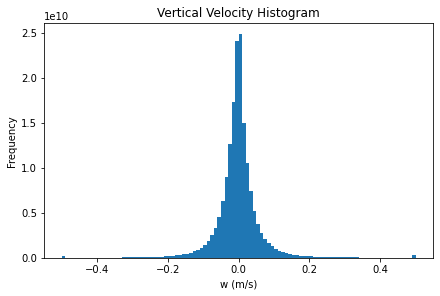

In [28]:
%matplotlib inline
edges_centered = (hist_edges[:-1] + hist_edges[1:])/2
# hist_cummulative[0], hist_cummulative[-1] = 0,0
fig, ax = plt.subplots(constrained_layout=True)
ax.bar(edges_centered, hist_cummulative, width=np.diff(hist_edges))
# ax.axvline(0.05, c='green', ls='--')
# ax.axvline(0.1, c='#f7dc0f', ls='--')
ax.set_title(f'Vertical Velocity Histogram')
ax.set_xlabel('w (m/s)')
ax.set_ylabel('Frequency')

# fig.savefig(f'Processed/Figures/w_distribution_7days.png', dpi=600)
plt.show()